Import necessary packages: Numpy, Pandas, matplotlib

In [117]:
import numpy as np
import pandas as pd
import operator, random, time, itertools
from matplotlib import pyplot as plt
from collections import Counter

In [118]:
training_data = np.array(pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.train.gz', sep=' ', header=None))
test_data = np.array(pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/zip.test.gz', sep =' ',header=None))

X_train, y_train = training_data[:,1:-1], training_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]

In [119]:
def show_numbers(X):
    num_samples = 90
    indices = np.random.choice(range(len(X)), num_samples)
    sample_digits = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(6, 15, i + 1)
        img = 1-sample_digits[i].reshape((16, 16)) 
        plt.imshow(img, cmap='gray')
        plt.axis('off')

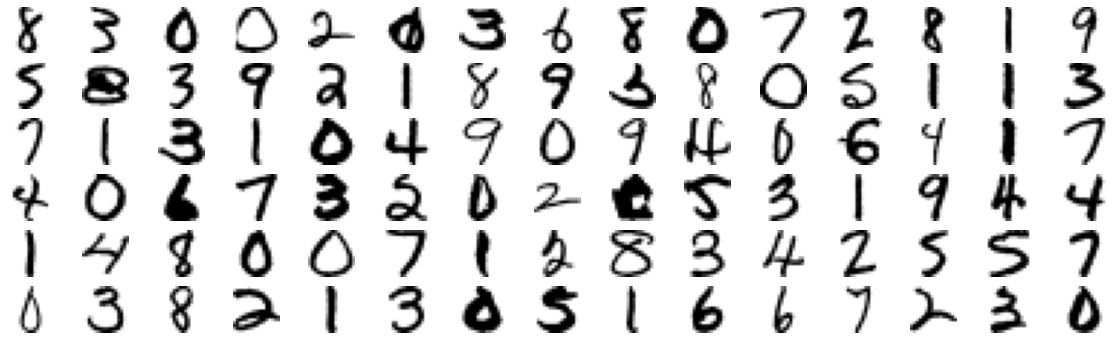

In [120]:
show_numbers(X_test)

Overall Runtime:  33.01555871963501  Seconds


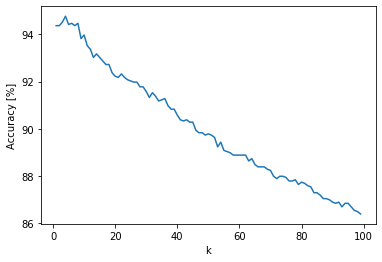

-----Wrong recognized numbers-----


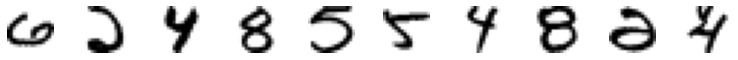

--------------------------------------------------
[VARIANCE]   : 0.27390845132307723
[RUNTIME]    : 350.627158164978 

          POSITIVE    NEGATIVE
TRUE   1412.559596  306.307071
FALSE   116.862626   23.870707

[PRECISION]  : 0.9235903437490094
[RECALL]     : 0.9833819246082811
[F1-SCORE]   : 0.9525487757280343


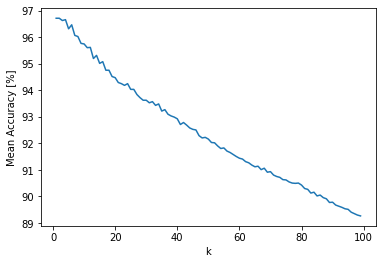

In [121]:
class CrossValidation():
    #Shuffles and partitions datasets in x folds 
    def data_refactoring(self, data:[...] = [X_train, y_train, X_test, y_test], folds:int = 5) -> [[...],[...],...]:
        data_set = list(zip(data[0], data[1])) + list(zip(data[2], data[3]))
        return (np.array(np.array_split(np.array(random.sample(data_set,len(data_set))),folds)))
    
    #Cross validates algorithm with x folds
    def testing_algorithm(self, k, data, folds, pl_flag):
        global y_test, y_train
        timer = time.time()
        kNN, plot = KNearestNeighbors(), Plotting()
        f_acc, cA = [], []
        for x in range(folds):
            X_train, y_train = zip(*list(np.concatenate(data[np.arange(len(data))!=x])))    #Train-Dataset  (folds - 1)
            X_test, y_test = zip(*(list(data[x])))                                          #Test-Dataset   
            z = (kNN.main(k, X_train, X_test, pl_flag, 1))
            f_acc.append(z[0])
            cA.append([np.mean(k) for k in zip(*z[1])])

        acc_mean = [np.mean(k) for k in zip(*f_acc)]
        cA = [np.mean(k) for k in zip(*cA)]
        variance = [(x[1]-acc_mean[x[0]])**2 for x in enumerate(np.array(f_acc[0]))]
        print("[VARIANCE]   :", sum(variance)/len(acc_mean))
        print("[RUNTIME]    :", time.time()-timer, "\n")
        print(pd.DataFrame(np.array([[cA[0], cA[1]], [cA[2], cA[3]]]),
                   columns=['POSITIVE', 'NEGATIVE'], index=['TRUE', 'FALSE']))
        precision, recall = cA[0]/(cA[0]+cA[2]), cA[0]/(cA[0]+cA[3]) 
        print("\n[PRECISION]  :", precision)
        print("[RECALL]     :", recall)
        print("[F1-SCORE]   :", (2*precision*recall)/(precision+recall))
        plot.general_plotter(k, acc_mean, "k", "Mean Accuracy [%]")

class Plotting():
    def general_plotter(self, x, y, xlabel, ylabel):                                                    #Just a modularization of the plotting function
        plt.plot(x, y)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

class KNearestNeighbors():
    #Sorting Algorithm which returns only the nearest sorted k neighbors and indexes them
    def neighboursort(self, k, a, f) -> [(int,int)]:
        if (f):
            z = list(zip(a,list(range(k))))
            z = sorted(z)                                                                       #sorting k numbers to improve efficiency a lot
            for n in range(k,len(a)):                                                           #if any number in a is smaller than z[i][0], replace z[i][0] with (a[n],n), else test z[i+1][0]
                for i in range(0,k):                                                            #(it is works pretty much like an enhanced bubblesort, but with an better runtime (Should be arround O(1.2k*n)))
                    if (a[n]<z[i][0]):
                        z[i] = (a[n],n)
                        break      
            return(z) 
        return(sorted(list(zip(a,list(range(len(a)))))))                                        #indexing every entry in a, timsorts and returns it

    #counts occurrences in a and returns max
    def vote_neighbourhood(self, a) -> int:
        z = []
        for n in range(len(a)):
           z.append(y_train[a[n][1]])                                                           #translates the returned indexes from neighboursort to their respective number (y_train[index])
        d = Counter(z)
        if (len(d) == 1):
            return (z[0])     
        return (max(d.items(), key=operator.itemgetter(1))[0])
    
    #Calculates the euclidiean distance (duh)
    def squared_euclidean_distance(self, x_1, x_2) -> [int]:
      return np.sum((x_1-x_2)**2, axis = 1)

    #tests the calculated image-numbers against their actual value (y_train[x])
    def acc_scan(self, a, ytest) -> float:
        c, tp, tn, fp, fn, w = 0, 0, 0, 0, 0, []                                                #c = accuracy counter, w = array with wrong calculated numbers
        for n in range(len(ytest)):
            if (a[n] == ytest[n]):
                if (a[n]):
                    tp+= 1
                else:
                    tn += 1
                c+= 1
            else:
                if (a[n]):
                    fp+= 1
                else:
                    fn+= 1
                w.append(n)
        return ([(c/len(ytest))*100,w, [tp, tn, fp, fn]])

    #Prints out the numbers, which were not correctly recognized
    def wrong_number(self, indices, train = X_train):
        print("-----Wrong recognized numbers-----")
        samples = (10 if len(indices)>=10 else len(indices))                                        #checking if < 10 wrong calculated numbers are present in array indices
        plt.figure(figsize=(20, 6))                                                                 #Formatting image 
        for i in range(samples):
            plt.subplot(6, 15, i + 1)                                                               #Scaling x/y
            plt.imshow(1-X_test[indices][i].reshape((16, 16)), cmap='gray')
            plt.axis('off')
        plt.show()
    
    #                 --- DRIVER CODE --- 
    # k <- [int]        : How many neighbours are needed to become a clusterpoint
    # train <- [[int]]  : Train dataset 
    # test <- [[int]]   : Test dataset
    # pl_flag <- [0|1]  : Plots statistics on how well the algorithm performed
    # cv_flag [0|1]     : Is needed for cross validation, don't change it manually
    def main(self, k = [2,5], train = X_train, test = X_test, pl_flag = 1, cv_flag = 0):
        global acc
        timer = time.time()
        pl, counted_acc, t = [], [], []                                                             #pl = saved accuracies, t = saved runtimes
        f = (len(k)<=2)                                                                             #switching to lighter calc. algo if len(k) <= 2 
        if (f):
            for i in k: 
                r = []                                                                              #r = results of voteNeighbourhood for every testnumber
                for n in range(len(test)):
                    r.append(self.vote_neighbourhood(self.neighboursort(i, self.squared_euclidean_distance(train, test[n]), f)))
                acc = self.acc_scan(r, y_test)
                cv_flag == 0 and print ("[ k =", i, "] Accuracy:", acc[0], "%")
                if (pl_flag or cv_flag):
                    pl.append(acc[0])
                    t.append(time.time()-timer)
                    counted_acc.append(acc[2])
                timer = time.time()
        else:
            z, uA, oA = [],[],[]                                                                     #z = container for nsort results, uA = vote results for one k, oA = matrix for every respective vote result
            for n in range(len(test)):
                z.append(self.neighboursort(-1, self.squared_euclidean_distance(train, test[n]), f))
                for i in k:
                    uA.append(self.vote_neighbourhood(z[n][:i]))                                     #calls vN with only the first k entries of z
                oA.append(uA)                                                                        #(Every entry in oA is a matrix, where every element of said matrix corresponds to)
                uA = []                                                                              #(the voted number from vN in respect to k)
            for x in range(len(oA[0])):
                acc = self.acc_scan([i[x] for i in oA], y_test)                                      #acc-check of every first/second/... element in n-touple of oA
                len(k)<=25 and cv_flag == 0 and print ("[ k =", k[x], "] Accuracy:", acc[0], "%")    #spam-protector
                if (pl_flag == 1 or cv_flag):
                    pl.append(acc[0])
                    counted_acc.append(acc[2])
            cv_flag == 0 and print ("Overall Runtime: ", time.time()-timer, " Seconds")
        if (cv_flag):
            return ((pl, counted_acc))
        elif (len(k)>1 and pl_flag):
            plot = Plotting()
            plot.general_plotter(k, pl, 'k', 'Accuracy [%]')
            f and general_plotter(k, t, 'k', 'runtime [s]')
            self.wrong_number(acc[1], train)                                    

#Fast tests without cross validation (A lot faster!)
kNN = KNearestNeighbors()
kNN.main(list(range(1,100)))
print("--------------------------------------------------")
#cV will alter the base-data so if you want to use cV, run the whole program (in case you use colab),
#cV last or reset the data after every function call manually
cV = CrossValidation()
cV.testing_algorithm(list(range(1,100)), cV.data_refactoring(), 5, 0)